<a href="https://colab.research.google.com/github/alireza12t/Anomaly-Detectioon-with-VAE/blob/main/Copy_of_Alireza_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install glob

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [ ]:
!pip install numpy==1.19.5

## Importing Libraries

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import glob

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, DenseFeatures, Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import losses

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

## Load Data

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
trainPaths = glob.glob('/content/drive/MyDrive/dataset/train/**/conn.log.labeled', recursive=True)

trains = []
for train_path in trainPaths:
  df = pd.read_csv(train_path, sep='\t', skiprows=[1,2,3,4,5,6,7] ,names=['ts', 'uid', 'id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp-bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label'])
  trains.append(df)
  
train = pd.concat(trains, axis = 0).iloc[1: , :]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
testPaths = glob.glob('/content/drive/MyDrive/dataset/test/**/conn.log.labeled', recursive=True)

tests = []
for test_path in testPaths:
  df = pd.read_csv(test_path, sep='\t', skiprows=[1,2,3,4,5,6,7] ,names=['ts', 'uid', 'id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp-bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label'])
  tests.append(df)
  
test = pd.concat(tests, axis = 0).iloc[1: , :]

## Preprocess Data

In [ ]:
train['label'] = pd.np.where(train.label.str.contains('Malicious '), 0, 1)
train = train.replace('-', float('NaN'))
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


,ts,uid,id_orig_h,id_orig_p,id_resp_h,id_resp_p,proto,service,duration,orig_bytes,resp-bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
1,1538478769.600293,CSQG794riQ4XnzTxP2,192.168.100.103,37082.0,192.168.100.1,53.0,udp,dns,5.005151,78,0,S0,NaN,NaN,0.0,D,2.0,134.0,0.0,0.0,1
2,1538478779.610847,COTbdG2BhtGBlmf6r,192.168.100.103,34486.0,192.168.100.1,53.0,udp,dns,0.007243,90,90,SF,NaN,NaN,0.0,Dd,2.0,146.0,2.0,146.0,1
3,1538478789.630642,CP48WJ2HOnLuGtr5kb,192.168.100.103,37601.0,192.168.100.1,53.0,udp,dns,0.002250,90,90,SF,NaN,NaN,0.0,Dd,2.0,146.0,2.0,146.0,1
4,1538478779.620088,CeTMJi2TydRSaVdsG4,192.168.100.103,46439.0,192.168.100.1,53.0,udp,dns,5.005154,78,0,S0,NaN,NaN,0.0,D,2.0,134.0,0.0,0.0,1
5,1538478799.645444,CZ6ne24AN9WAg9XA9d,192.168.100.103,55174.0,192.168.100.1,53.0,udp,dns,0.002246,90,90,SF,NaN,NaN,0.0,Dd,2.0,146.0,2.0,146.0,1


In [ ]:
# find columns with more than 50 percent Nan Values
train.isnull().sum(axis=0)/train.shape[0]*100

ts                 0.000000
uid                0.000256
id_orig_h          0.000598
id_orig_p          0.000598
id_resp_h          0.000598
id_resp_p          0.000598
proto              0.000598
service           99.004143
duration          74.469182
orig_bytes        74.469182
resp-bytes        74.469182
conn_state         0.000598
local_orig       100.000000
local_resp       100.000000
missed_bytes       0.000598
history            1.590981
orig_pkts          0.000598
orig_ip_bytes      0.000598
resp_pkts          0.000598
resp_ip_bytes      0.000598
label              0.000000
dtype: float64

In [ ]:
nan_columns = ['local_resp', 'local_orig', 'resp-bytes', 'service', 'duration', 'orig_bytes']
train = train.drop(nan_columns, axis=1).dropna()

In [ ]:
train.shape

(1152717, 15)

In [ ]:
# last column is the target
# 0 = anomaly, 1 = normal
test['label'] = pd.np.where(test.label.str.contains('Malicious '), 0, 1)
test = test.replace('-', float('NaN'))
test = test.drop(nan_columns, axis=1).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until


## Scale the data using MinMaxScaler

In [ ]:
df = pd.concat([train, test])
labels = np.where(df['label'] == 1, 1, 0)

symbolic_coloumns = ['proto', 'conn_state', 'history']
samples = pd.get_dummies(df.iloc[:, :-1], columns=symbolic_coloumns).drop(['uid', 'ts', 'id_orig_h', 'id_resp_h', 'id_orig_p', 'id_resp_p'], axis=1)

In [ ]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(samples)

In [ ]:
# generate train set
# training set will consist of the normal ds
X_train = df_scaled[:len(train)][labels[:len(train)] == 1]

#sklearn split

# generate test set again
X_test = df_scaled[len(train):]
y_test = labels[len(train):]

In [ ]:
samples.head()

,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,proto_tcp,proto_udp,conn_state_OTH,conn_state_REJ,conn_state_RSTO,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR,history_Ar,history_C,history_CCC,history_CCCC,history_D,history_DFafA,history_D^,history_D^d,history_Dd,history_DdA,history_DdAtaFf,history_F,history_Fa,history_FaAr,history_FaR,history_FfA,history_Ffa,history_Fr,history_HaADdFf,history_HaDdAFTf,...,history_ShAdDatfF,history_ShAdDatfr,history_ShAdDatrfR,history_ShAdDfFa,history_ShAdDfFr,history_ShAdDfr,history_ShAdDr,history_ShAdDtaFf,history_ShAdDtaFr,history_ShAdDtafF,history_ShAdDtafFr,history_ShAdF,history_ShAdFaf,history_ShAdaFr,history_ShAdfDFr,history_ShAdfDr,history_ShAdfFa,history_ShAdr,history_ShAdtDaFr,history_ShAdtDaFrR,history_ShAdtDafF,history_ShAfFa,history_ShAfdtDFr,history_ShAfdtDr,history_ShAr,history_ShArR,history_ShDadAf,history_ShR,history_ShrA,history_Sr,history_^aA,history_^aR,history_^d,history_^dDA,history_^hA,history_^hADFr,history_^hADadfR,history_^hADafF,history_^hADr,history_^r
1,0.0,2.0,134.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,2.0,146.0,2.0,146.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,2.0,146.0,2.0,146.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,2.0,134.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.0,2.0,146.0,2.0,146.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Build AutoEncoder model

In [ ]:
# The reparameterization trick
def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon   

In [ ]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [ ]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 216)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 108)          23436       ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 72)           7848        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 72)           7848        ['dense[0][0]']                  
                                                                                            

In [ ]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 72)]              0         
                                                                 
 dense_1 (Dense)             (None, 108)               7884      
                                                                 
 dense_2 (Dense)             (None, 216)               23544     
                                                                 
Total params: 31,428
Trainable params: 31,428
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# full Variational Autoencoder model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [ ]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)

tf.config.run_functions_eagerly(False)
vae_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=20,
                        validation_data=(X_test, y_test)
                        )

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 216)]             0         
                                                                 
 encoder (Functional)        (None, 72)                39132     
                                                                 
 decoder (Functional)        (None, 216)               31428     
                                                                 
Total params: 70,560
Trainable params: 70,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
14427/14427 [==============================] - 37s 2ms/step - loss: 0.0024 - val_loss: 0.0947
Epoch 2/20
14427/14427 [==============================] - 36s 2ms/step - loss: 0.0024 - val_loss: 0.0947
Epoch 3/20
14427/14427 [==============================] - 35s 2ms/step - loss: 0.0024 - val_loss: 0.0947
Epoc

## Classification Report

In [ ]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [ ]:
X_train_pred = vae_model.predict(X_train)

mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')

Avg error 0.0023631082656985687
median error 2.5344469170128764e-07
99Q: 0.018520176151207664


In [ ]:
tf.config.run_functions_eagerly(False)
training_loss = losses.mse(X_train, vae_model(X_train))
error_thresh = np.mean(training_loss)+np.std(training_loss)
print(f'setting threshold on { error_thresh } ')

setting threshold on 0.008687186054885387 


In [ ]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)
anomalies = np.where(anomalies, 0, 1)

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21222
           1       1.00      0.51      0.67      1923

    accuracy                           0.96     23145
   macro avg       0.98      0.75      0.83     23145
weighted avg       0.96      0.96      0.95     23145



## Analyse Data

In [ ]:
X_encoded = encoder.predict(X_test)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

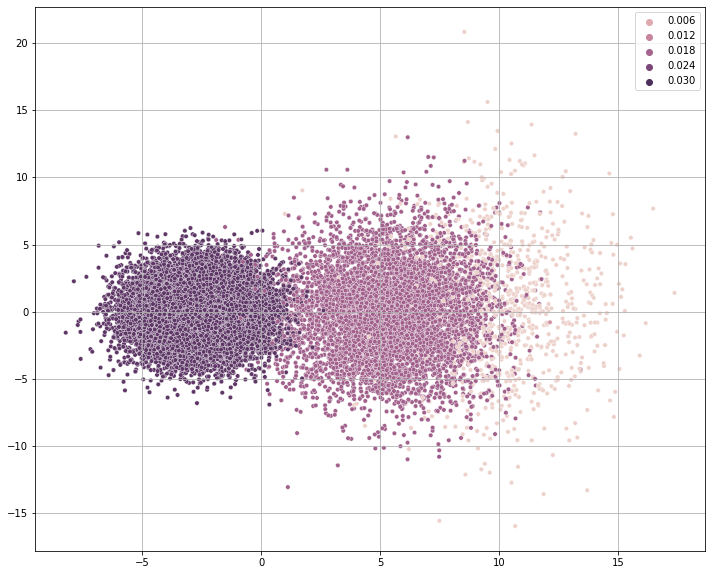

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

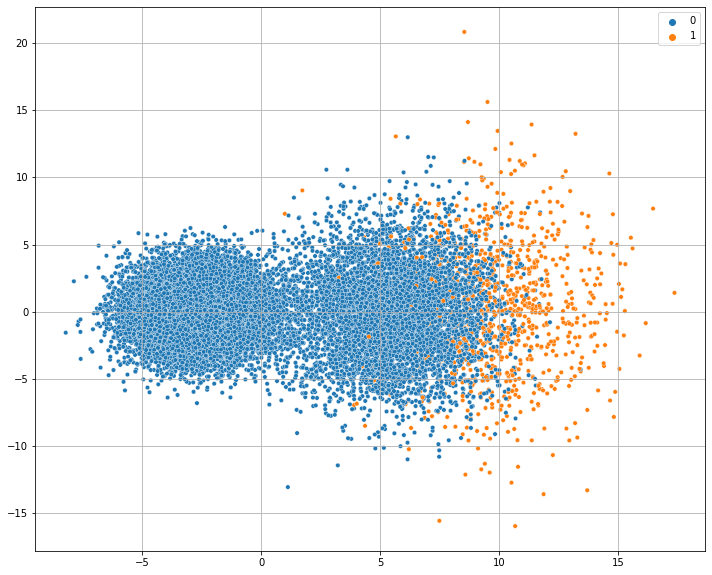

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

## Receiver Operating Characteristic (ROC) - Test Data

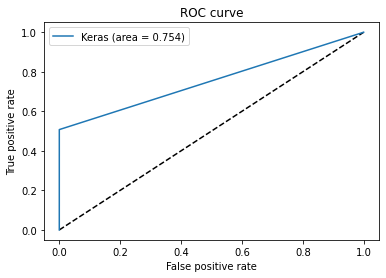

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, anomalies)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Reconstruction Loss Curve

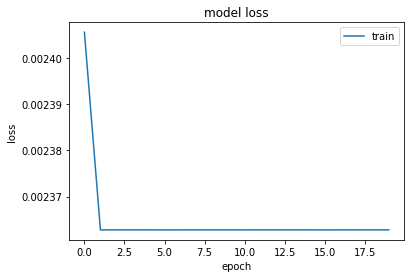

In [ ]:
plt.plot(results.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()